In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

!rm -f datos.zip
!rm -rf datos
!wget 'https://robertohincapie.com/qetuo1357/datos.zip'
!unzip -q datos.zip
!rm -f datos.zip

translate={'Alberta':'Alberta','BC':'British Columbia','Manitoba':'Manitoba','New Brunswick':'New Brunswick','NL':'Newfoundland and Labrador',
'NWT':'Northwest Territories','Nova Scotia':'Nova Scotia','Nunavut':'Nunavut', 'Ontario':'Ontario', 'PEI':'Prince Edward Island',
'Quebec':'Quebec', 'Saskatchewan':'Saskatchewan', 'Yukon':'Yukon','Repatriated':'Repatriated'}

states=list(translate.values())

#Canada and provinces daily cases
data=pd.read_csv("datos/CLEANED_Daily_cases-Canada_noQuot.csv", parse_dates=['date_report'])

#Mobility data from air traffic
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%d-%m")
source_0=pd.read_csv("datos/CLEANED_OriginIntlToCanada__2010-2021.csv", sep=',', parse_dates=['Date'], date_parser=custom_date_parser)[['Origin city', 'Province / state','Country', 'Direct volume', 'Indirect volume', 'Total volume', 'Date']]
dest_0=pd.read_csv("datos/CLEANED_DestIntlToCanada__2010-2021.csv", sep=',', parse_dates=['Date'], date_parser=custom_date_parser)[['Destination city', 'Province / state','Country', 'Direct volume', 'Indirect volume', 'Total volume', 'Date']]
manitoba=pd.read_csv("datos/CLEANED_OriginIntlToManitoba__2010-2021.csv", sep=',', parse_dates=['Date'], date_parser=custom_date_parser)[['Origin city', 'Province / state','Country', 'Direct volume', 'Indirect volume', 'Total volume', 'Date']]
#World Covid Data: 
#Cummulative: https://github.com/CSSEGISandData/COVID-19/blob/5b71a48af53f961c3ef99617647bab20571e2f4e/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
#deaths: https://github.com/CSSEGISandData/COVID-19/blob/5b71a48af53f961c3ef99617647bab20571e2f4e/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
#Recovered: https://github.com/CSSEGISandData/COVID-19/blob/5b71a48af53f961c3ef99617647bab20571e2f4e/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
world_new=pd.read_csv('datos/covid_world.csv', sep=',')

#Reduction of countries in world_new which we have no information
remove=["Burma","Cote d'Ivoire","Diamond Princess","Kosovo","MS Zaandam","West Bank and Gaza", "Summer Olympics 2020"]
for co in remove:
    world_new=world_new[world_new['Country/Region']!=co]
    
#US_data: https://github.com/CSSEGISandData/COVID-19/blob/5b71a48af53f961c3ef99617647bab20571e2f4e/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
us_new=pd.read_csv('datos/us_covid.csv', sep=',')
us_new=us_new[us_new.columns[11:]].sum()
us_new.index=pd.to_datetime(us_new.index)
us_new=us_new.diff().fillna(0)

#World population
#https://www.kaggle.com/tanuprabhu/population-by-country-2020
population=pd.read_csv('datos/population_by_country_2020.csv', sep=',')[['Country (or dependency)', 'Population (2020)']]
population.columns=['Country','Population']
population.loc[population.Country=='South Korea','Country']='Korea, South'
population.loc[population.Country=='DR Congo','Country']='Congo (Kinshasa)'
population.loc[population.Country=='Congo','Country']='Congo (Brazzaville)'
population.loc[population.Country=='Czech Republic (Czechia)','Country']='Czechia'
population.loc[population.Country=='Saint Kitts & Nevis','Country']='Saint Kitts and Nevis'
population.loc[population.Country=='St. Vincent & Grenadines','Country']='Saint Vincent and the Grenadines'
population.loc[population.Country=='Sao Tome & Principe','Country']='Sao Tome and Principe'
population.loc[population.Country=='Taiwan','Country']='Taiwan*'

#Canadian population
#https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
canada_pop=pd.read_csv('datos/canadian_population.csv',sep=';')
canada_pop.index=canada_pop['Geography']
pop={}
for st in states:
  if(st!='Repatriated'):
    print(st)
    pop[st]=canada_pop.loc[st]['Q2 2021']    

In [ ]:
us_states=source_0[source_0['Country']=='United States']['Province / state'].unique().tolist()

new_


100%|██████████| 272/272 [00:00<00:00, 466.77it/s]


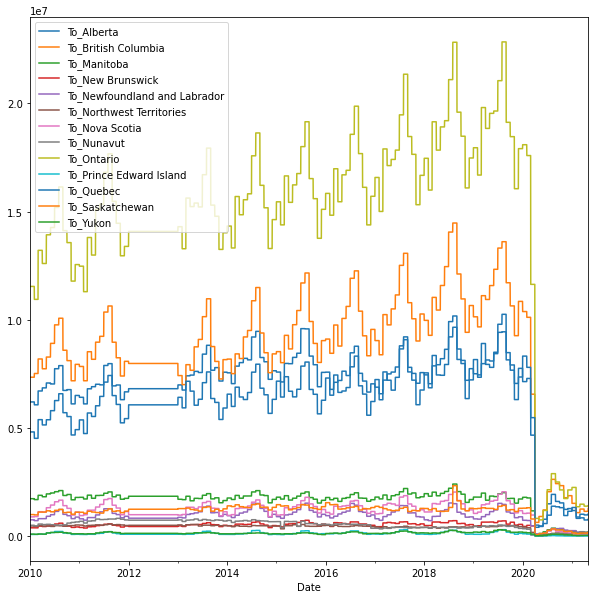

In [ ]:
#Data processing
provs=data['province'].unique().tolist()
dates=data['date_report'].unique()
df=pd.DataFrame(index=dates, columns=provs)
df=df.fillna(0)
for i in range(len(data)):
    fecha=data.iloc[i]['date_report']
    prov=data.iloc[i]['province']
    num=data.iloc[i]['daily_cases']
    df.loc[fecha][prov]=num
    
for co in df.columns:
    df[co]=df[co].rolling(window=20, center=True).mean().fillna(method='ffill')
co=['Daily_'+translate[c] for c in df.columns]
df.columns=co
df=df.fillna(0)

countries=source_0.Country.unique().tolist()
#Data frame conversion to pivot tables needed
def read(df, col, prefix=''):
    data=pd.pivot_table(df, values='Total volume', index='Date', columns=col, aggfunc=np.sum)
    data=data.asfreq('D', method='ffill')
    cols=data.columns
    cols=[prefix+co for co in cols]
    data.columns=cols
    data=data.fillna(0)
    data=data*10
    return data

source=read(source_0, 'Country', prefix='From_')
sourceUS=read(source_0[source_0['Country']=='United States'], 'Province / state', prefix='US_From_')
dest=read(dest_0, 'Province / state', prefix='To_')
#source.plot()
#plt.figure(figsize=(10,10))
dest.plot(figsize=(10,10))
cols_daily, cols_source, cols_dest=df.columns, source.columns, dest.columns
df=df.join(dest).join(source).join(sourceUS)
#print('Fecha máxima: ',max(df.index))
fechas=world_new.columns[4:]
countries=list(world_new['Country/Region'].unique())
#print(df[df.index<pd.to_datetime('2021-05-15')].tail(20))
cols=['new_'+co for co in countries]#+['death_'+co for co in countries]+['recovered_'+co for co in countries]
covid=pd.DataFrame(index=fechas, columns=cols)
covid=covid.fillna(0)
for df2, pref in zip([world_new],['new_']):
    print(pref)
    for i in tqdm(range(len(df2))):
        country=df2.iloc[i]['Country/Region']
        covid[pref+country]+=df2.iloc[i][fechas]
covid.index=pd.to_datetime(covid.index)
covid=covid.asfreq('D', method='ffill')
for co in covid.columns:
    covid[co]=covid[co].rolling(window=20, center=True).mean().fillna(method='ffill')
covid=covid.diff()
covid.fillna(0)
df=df.join(covid)
df=df.fillna(0)

#Saving of canadian states population
for st in states:
  if(st!='Repatriated'):
    df['Population_'+st]=pop[st]

In [ ]:
#Estimation of the number of active cases, simply by reducing the number of users newly infected after 14 days
for co in countries:
    newCases=list(df['new_'+co].values)
    n=14
    recovered=[0 for i in range(n)]+newCases[:-n]
    acum=np.cumsum(newCases)
    recov=np.cumsum(recovered)
    active=acum-recov
    df['active_'+co]=active


In [ ]:
df['new_US']=0
for ind in df.index:
    df.loc[ind,'new_US']=us_new.loc[ind]
df['new_US']=df['new_US'].rolling(window=20, center=True).mean().fillna(method='ffill').fillna(0)
newCases=list(df['new_US'].values)
n=14
recovered=[0 for i in range(n)]+newCases[:-n]
acum=np.cumsum(newCases)
recov=np.cumsum(recovered)
active=acum-recov
df['active_US']=active

for st in states:
    newCases=list(df['Daily_'+st].values)
    n=14
    recovered=[0 for i in range(n)]+newCases[:-n]
    acum=np.cumsum(newCases)
    recov=np.cumsum(recovered)
    active=acum-recov
    df['active_'+st]=active
    
#Population information storage
for co in countries:
    #print(co)
    if(co=='US'):
        co2='United States'
    else:
        co2=co
    row=population[population.Country==co2]['Population'].values[0]
    df['Population_'+co]=row
    
#df rows: 
    #Daily_xx x: canadian state: new cases on the state per day
    #active_xx x: number of active cases on countries
    #From_xx x: traffic volume from country xx
    #To_xx x: traffic volume to state xx
    #Population_xx: population on country xx
    
#I guess I have it all

def intensity(row, countries, region):
    #Get the intensity of covid infection to regions
    K=np.sum([row['To_'+co] for co in states if co!='Repatriated'])
    if(K>0):
      factor=row['To_'+region]/K
    else:
      factor=0
    Iown=row['active_'+region]
    Iext=0
    for i in range(len(countries)):
        if('From_'+countries[i] in row):
            #print('From_'+countries[i])
            Iext+=factor*row['From_'+countries[i]]/30.42*row['active_'+countries[i]]/row['Population_'+countries[i]]
            #print(Io)
    return Iown, Iext

for st in states:
    if(st!='Repatriated'):
        print('Analizando: ',st)
        Iown=[]
        Iext=[]
        for i in range(len(df)):
          tmp=intensity(df.iloc[i], countries, st)
          Iown.append(tmp[0])
          Iext.append(tmp[1])
        Iext=np.convolve(Iext, [1,1,1,1,1,1,1])[0:len(Iown)]
        df['Intensity_'+st]=[Io+Ie for (Io,Ie) in zip(Iown, Iext)]
        df['Intensity_own'+st]=Iown
        df['Intensity_ext'+st]=Iext
        
df=df.fillna(0)


Analizando:  Alberta
Analizando:  British Columbia
Analizando:  Manitoba
Analizando:  New Brunswick
Analizando:  Newfoundland and Labrador
Analizando:  Northwest Territories
Analizando:  Nova Scotia
Analizando:  Nunavut
Analizando:  Ontario
Analizando:  Prince Edward Island
Analizando:  Quebec
Analizando:  Saskatchewan
Analizando:  Yukon


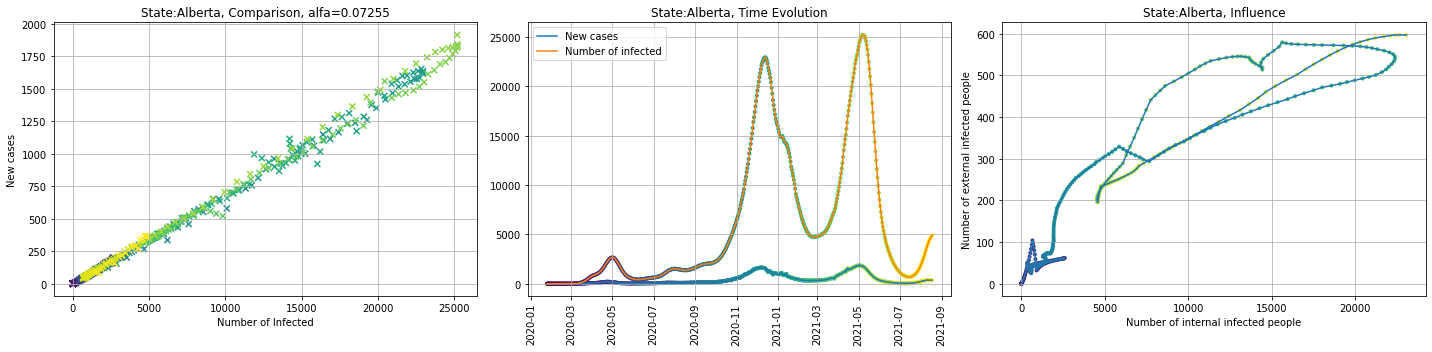

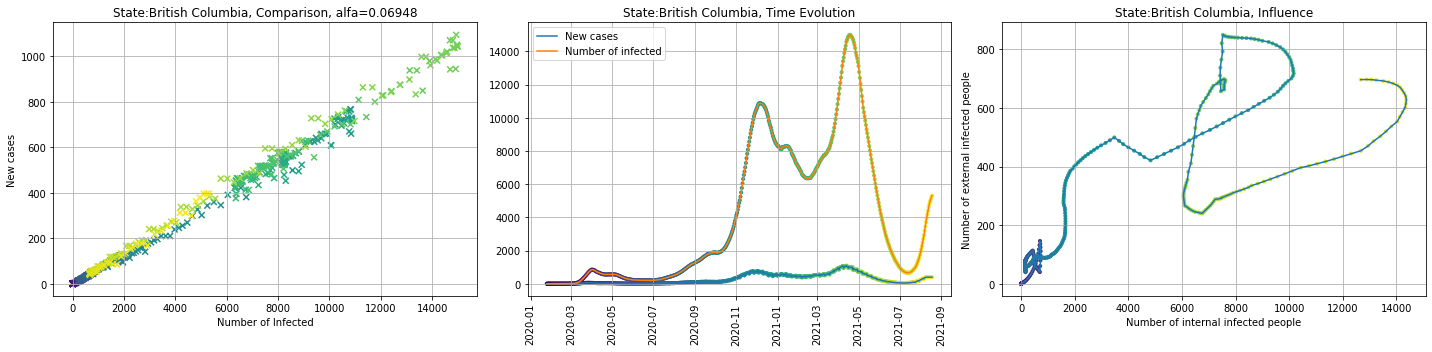

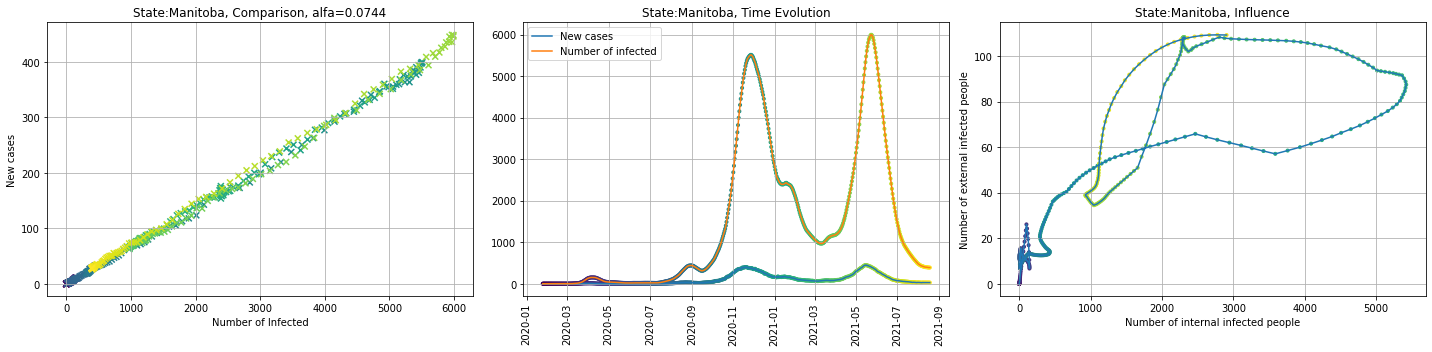

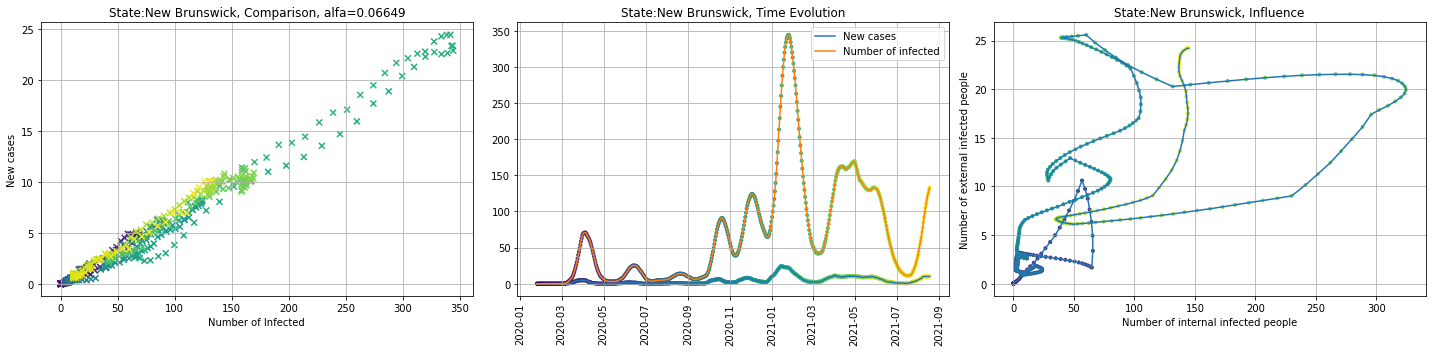

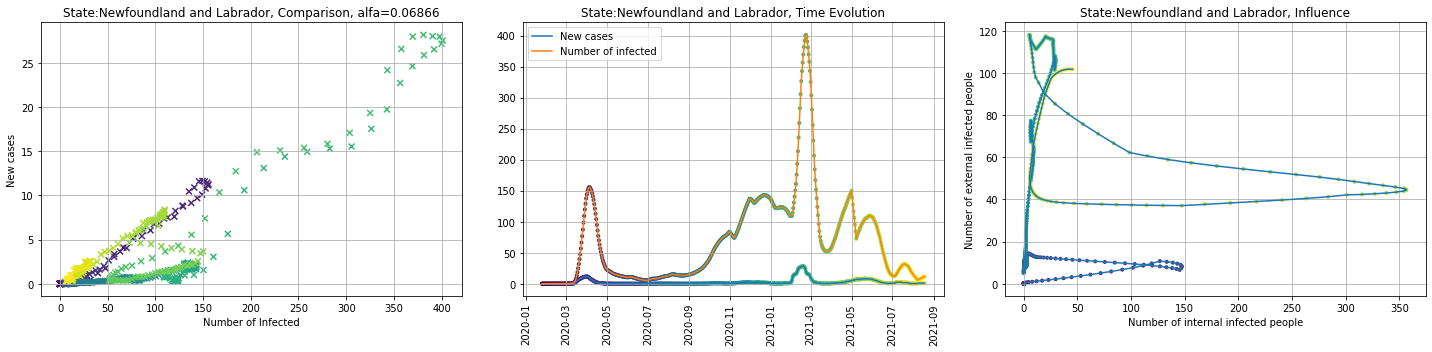

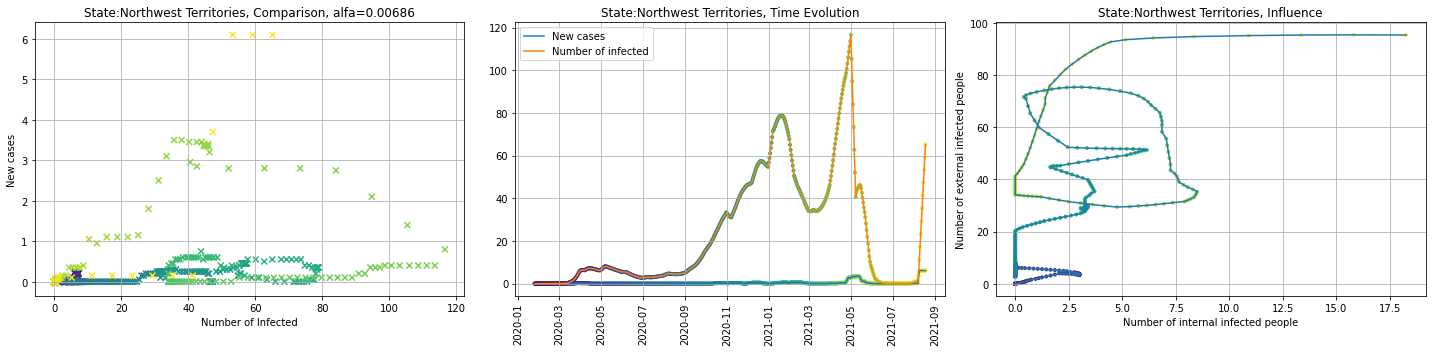

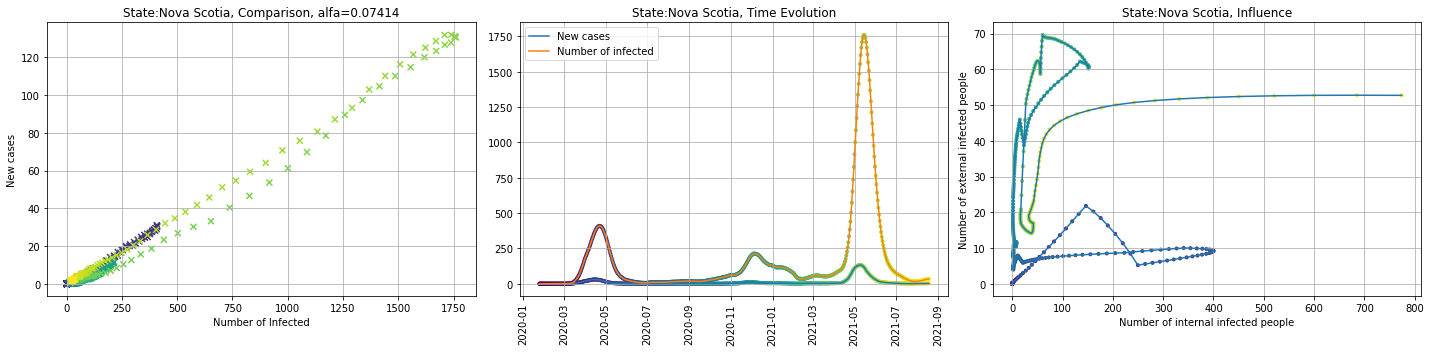

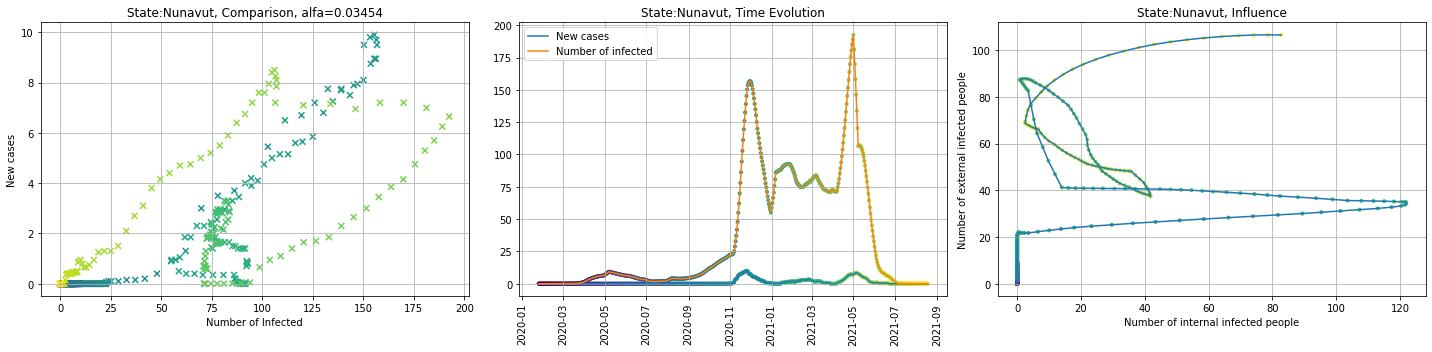

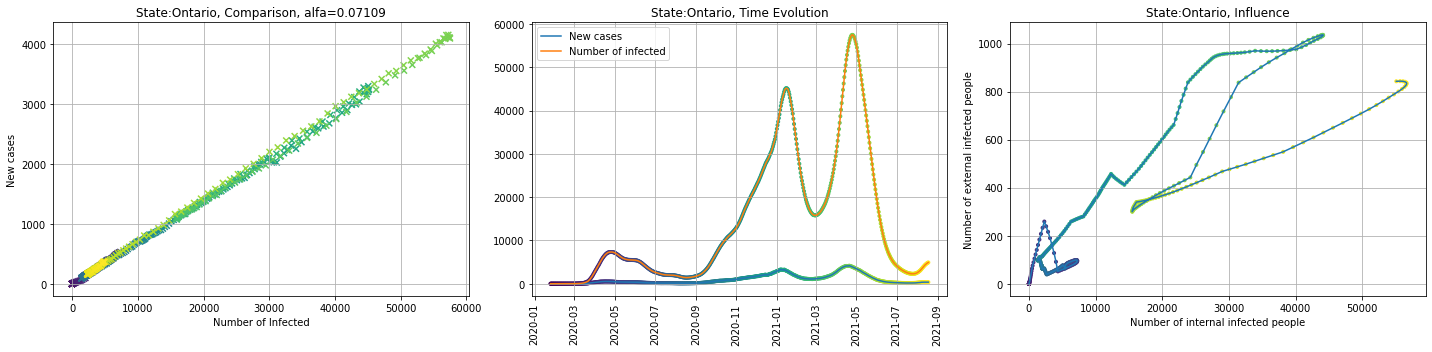

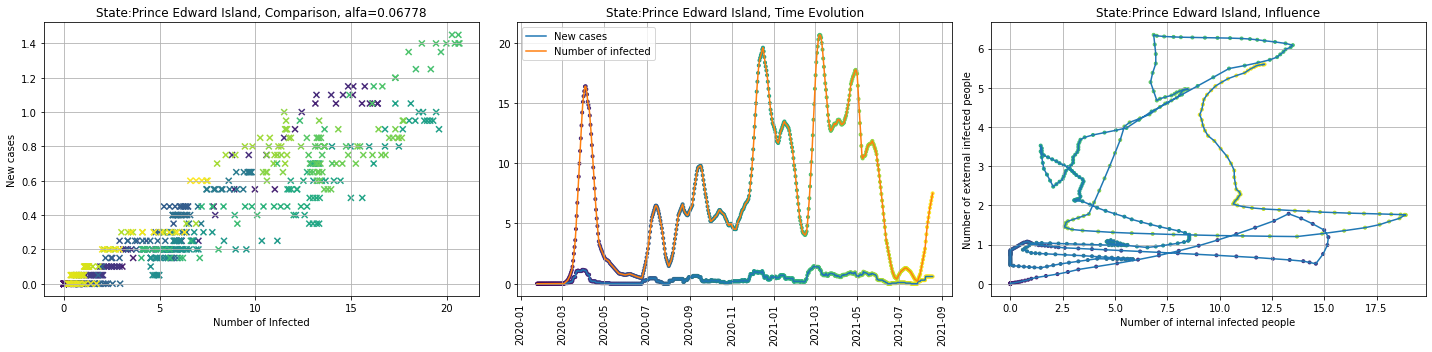

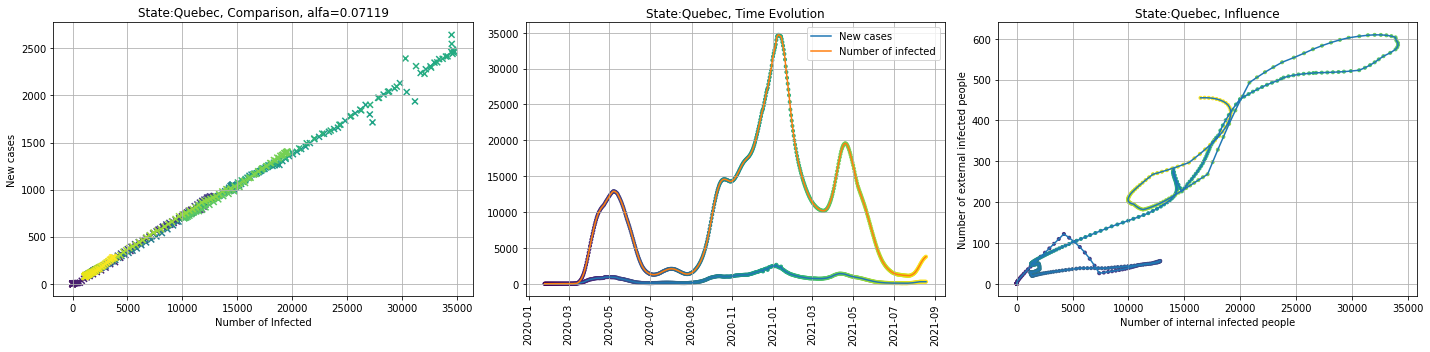

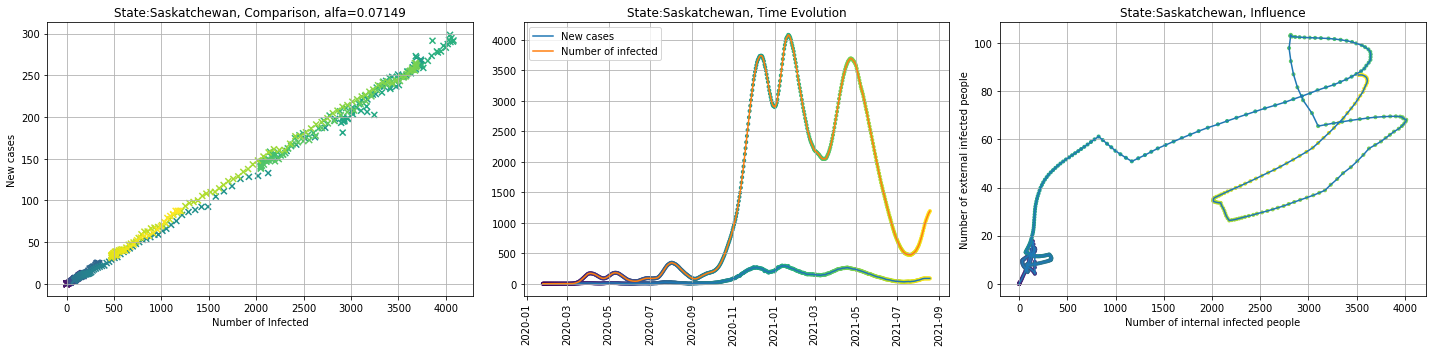

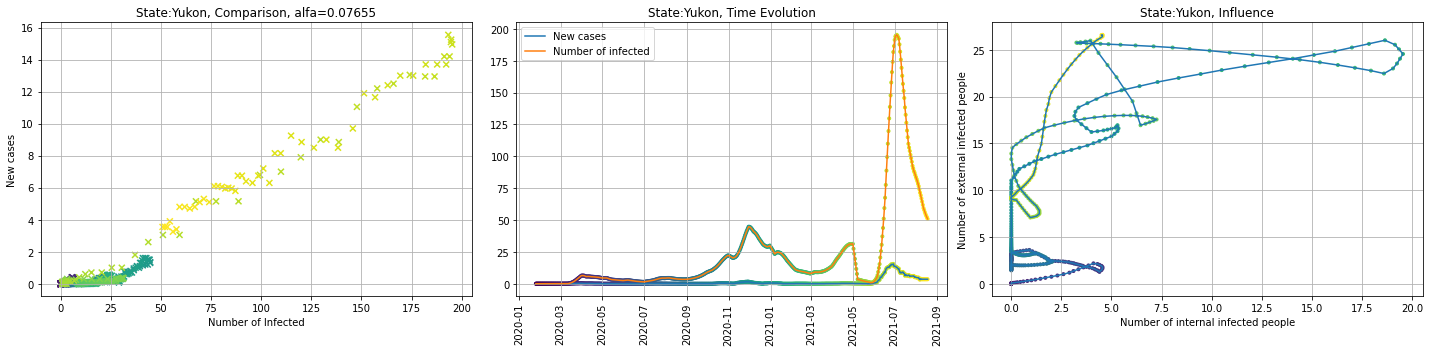

In [ ]:
def peakFind(x):
    y=np.exp(-(np.arange(-100,100)**2)/600)
    #plt.plot(x, label='x')
    d2=np.convolve(x,y)[100:]
    s=np.sign(np.diff(d2))
    s2=np.array([i for i in range(1, len(s)) if (0.5-s[i]*s[i-1]/2)*s[i-1]>0 ])
    #plt.plot(d2,label='conv')
    #for s in s2:
    #    plt.vlines(s, 0,np.max(x),color='r', linestyles='dashed')
    #plt.legend()
    return s2

plt.close('all')
for dt in [7]:
    for st in states:
        if(st!='Repatriated'):
            fig = plt.figure(figsize=(20,5))
            ax = plt.subplot(1,3,1)
            valores=df[['Daily_'+st, 'Intensity_'+st]].values
            peaks=peakFind(valores[:,1])
            #valores=valores[0:-10]
            tiempo=np.arange(0,(len(valores)-dt))
            x,y=valores[dt:,1],valores[0:(len(valores)-dt),0]
            ax.scatter(x,y,c=tiempo, marker='x')
            dist=x**2+y**2
            ind=np.argmax(dist)
            alfa=y[ind]/x[ind]
            #for p in peaks:
            #  ax.scatter(valores[p+dt,1],valores[p,0],marker='x', c='r')
            
            plt.ylabel('New cases')
            plt.xlabel('Number of Infected') 
            plt.title('State:'+st+', Comparison, alfa='+str(np.round(alfa,5)))
            plt.grid()
            ax=plt.subplot(1,3,2)
            plt.plot(df.index, df['Daily_'+st], '-', label='New cases')
            ax.scatter(df.index, df['Daily_'+st], c=np.arange(0,(len(valores))), marker='.')
            plt.plot(df.index, df['Intensity_'+st], '-', label='Number of infected')
            ax.scatter(df.index, df['Intensity_'+st], c=np.arange(0,(len(valores))), marker='.')
            #for p in peaks:
            #  plt.vlines(df.index[p], 0, valores[p,1], colors='r', linestyles='dashed')
            plt.xticks(rotation=90)
            plt.grid()
            plt.legend()
            plt.title('State:'+st+', Time Evolution')
            
            ax=plt.subplot(1,3,3)
            #plt.plot(df.index, df['Intensity_'+st], '-', label='Intensity')
            #plt.plot(df.index, df['Intensity_own'+st], '-', label='Intensity internal')
            #plt.plot(df.index, df['Intensity_ext'+st], '-', label='Intensity external')
            #date2='2020-06-15'
            #date=pd.to_datetime(date2)
            #plt.plot(df.loc[df.index<date]['Intensity_own'+st], df.loc[df.index<date]['Intensity_ext'+st], '-')
            #ax.scatter(df.loc[df.index<date]['Intensity_own'+st], df.loc[df.index<date]['Intensity_ext'+st], c=np.arange(0,(len(df.loc[df.index<date]))), marker='.')
            #plt.xlabel('Number of internal infected people')
            #plt.ylabel('Number of external infected people')
            #plt.plot(df.index, df['Intensity_own'+st], '-', label='Intensity internal')
            #plt.plot(df.index, df['Intensity_ext'+st], '-', label='Intensity external')
            #plt.grid()
            #plt.title('State:'+st+', Influence up to '+date2)
            
            #ax=plt.subplot(1,4,4)
            #plt.plot(df.index, df['Intensity_'+st], '-', label='Intensity')
            #plt.plot(df.index, df['Intensity_own'+st], '-', label='Intensity internal')
            #plt.plot(df.index, df['Intensity_ext'+st], '-', label='Intensity external')
            date=pd.to_datetime('2021-05-01')
            plt.plot(df.loc[df.index<date]['Intensity_own'+st], df.loc[df.index<date]['Intensity_ext'+st], '-')
            ax.scatter(df.loc[df.index<date]['Intensity_own'+st], df.loc[df.index<date]['Intensity_ext'+st], c=np.arange(0,(len(df.loc[df.index<date]))), marker='.')
            plt.xlabel('Number of internal infected people')
            plt.ylabel('Number of external infected people')
            #plt.plot(df.index, df['Intensity_own'+st], '-', label='Intensity internal')
            #plt.plot(df.index, df['Intensity_ext'+st], '-', label='Intensity external')
            plt.grid()
            plt.title('State:'+st+', Influence')
            plt.tight_layout()

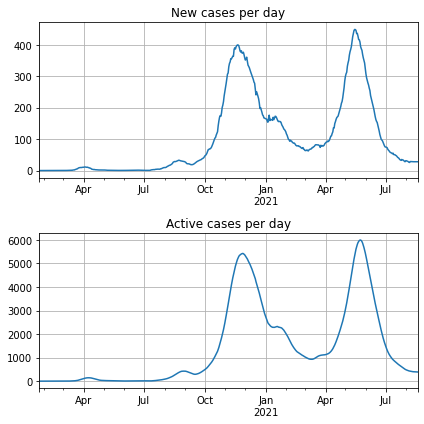

In [ ]:
#Figures for the document
st='Manitoba'
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
df['Daily_'+st].plot()
plt.title('New cases per day')
plt.grid()
plt.subplot(2,1,2)
df['active_'+st].plot()
plt.title('Active cases per day')
plt.grid()
plt.tight_layout()

In [ ]:
#Traffic volume analysis
def TrafficIntensity(row, countries, region):
  #Get the intensity of covid infection to regions
  K=np.sum([row['To_'+co] for co in states if co!='Repatriated'])
  if(K>0):
    factor=row['To_'+region]/K
  else:
    factor=0
  Io=0
  for i in range(len(countries)):
    if('From_'+countries[i] in row):
      Io+=factor*row['From_'+countries[i]]/30
  return Io

def getHistoricTrafficIntensity(countries, region):
  tmp=[]
  for i in range(len(df)):
    tmp.append(TrafficIntensity(df.iloc[i], countries, region))
  return tmp

for st in tqdm(states):
  if(st !='Repatriated'):
    tmp=getHistoricTrafficIntensity(countries, st)
    df['Traffic_'+st]=tmp


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


(array([737425., 737485., 737546., 737607., 737669., 737730., 737791.,
        737850., 737911., 737972., 738034.]),
 <a list of 11 Text major ticklabel objects>)

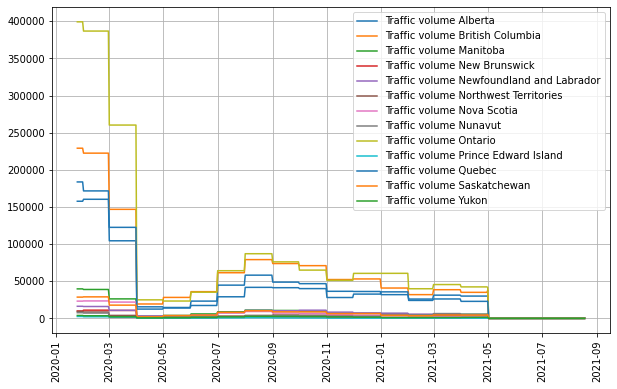

In [ ]:
plt.figure(figsize=(10,6))
for st in states:
  if(st !='Repatriated'):
    plt.plot(df.index, df['Traffic_'+st],'-', label='Traffic volume '+st)
plt.legend()
plt.grid()
plt.xticks(rotation=90)

In [ ]:
def read2(df, col, prefix=''):
    data=pd.pivot_table(df, values='Total volume', index='Date', columns=col, aggfunc=np.sum)
    data=data.asfreq('M', method='ffill')
    cols=data.columns
    cols=[prefix+co for co in cols]
    data.columns=cols
    data=data.fillna(0)
    data=data*10
    return data

source=read2(source_0, 'Country', prefix='From_')
dest=read2(dest_0, 'Province / state', prefix='To_')
#print(source.head())
def TrafficIntensity(origin, destination, countries, region):
  #Get the intensity of covid infection to regions
  K=np.sum([destination['To_'+st] for st in states if st!='Repatriated'])
  if(K>0):
    factor=destination['To_'+region]/K
  else:
    factor=0
  Io=0
  for i in range(len(countries)):
    if('From_'+countries[i] in origin):
      Io+=factor*origin['From_'+countries[i]]/30
  return Io

def getHistoricTrafficIntensity(countries, region):
  tmp=[]
  for i in range(len(source)):
    tmp.append(TrafficIntensity(source.iloc[i], dest.iloc[0], countries, region))
  return tmp

df2=pd.DataFrame(index=source.index)

for st in tqdm(states):
  if(st !='Repatriated'):
    tmp=getHistoricTrafficIntensity(countries, st)
    df2['Traffic_'+st]=tmp


100%|██████████| 14/14 [00:01<00:00,  7.02it/s]


            Traffic_Alberta  ...  Traffic_Yukon
Date                         ...               
2010-01-31    145675.425403  ...    2291.937796
2010-02-28    141680.828220  ...    2229.090076
2010-03-31    159710.724262  ...    2512.757689
2010-04-30    155121.071675  ...    2440.547856
2010-05-31    170486.287342  ...    2682.291571

[5 rows x 13 columns]


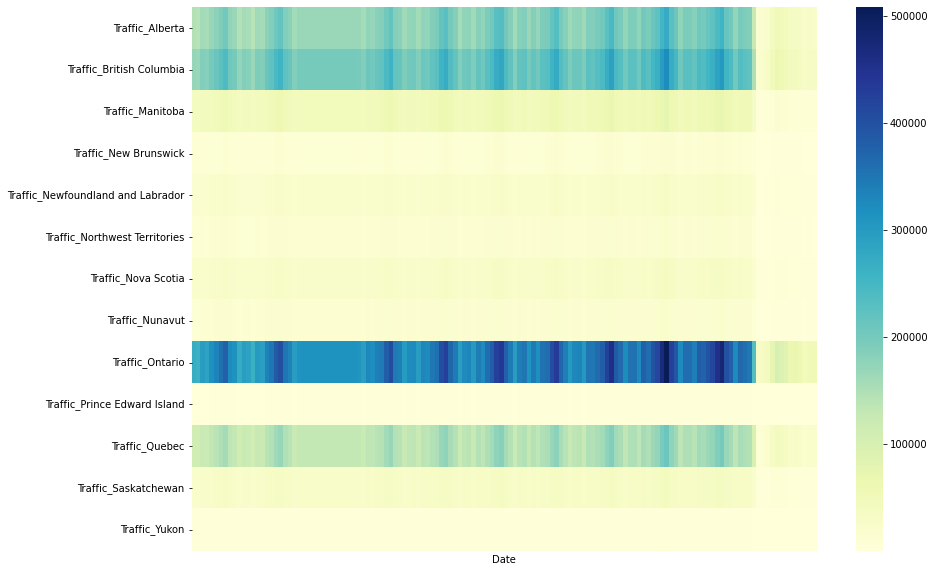

In [ ]:
#df2=df2
plt.figure(figsize=(14,10))
#for st in states:
#  if(st !='Repatriated'):
#    plt.plot(df2.index, df2['Traffic_'+st],'-o', label='Traffic volume '+st)
#plt.legend()
#plt.grid()
#plt.xticks(rotation=90)
print(df2.head())
df3=df2.copy()
#df3=df3.drop(['Total','Month','Year','TotalNormalized'], axis=1)
import seaborn as sns
sns.heatmap(df3.T, cmap="YlGnBu", xticklabels=False)

In [ ]:
#To represent each traffic curve as by the model: 
#V(month,state,year)=Vo(month)*Kyear*Kstate+w
#We need to find the best Vo(month) to minimize the noise projection
df2['Total']=df2[['Traffic_Alberta', 'Traffic_British Columbia', 'Traffic_Manitoba',
       'Traffic_New Brunswick', 'Traffic_Newfoundland and Labrador',
       'Traffic_Northwest Territories', 'Traffic_Nova Scotia',
       'Traffic_Nunavut', 'Traffic_Ontario', 'Traffic_Prince Edward Island',
       'Traffic_Quebec', 'Traffic_Saskatchewan', 'Traffic_Yukon']].sum(axis=1)
#tr.columns=['Traffic_volume']
#df2['Date']=df2.index
#month=[]
#for i in range(len(tr)):
#  month.append(tr.index[i].month)
df2['Month']=df2.index.month
df2['Year']=df2.index.year

print(df2.head())

            Traffic_Alberta  Traffic_British Columbia  ...  Month  Year
Date                                                   ...             
2010-01-31    145675.425403             172506.831203  ...      1  2010
2010-02-28    141680.828220             167776.484269  ...      2  2010
2010-03-31    159710.724262             189127.238691  ...      3  2010
2010-04-30    155121.071675             183692.235348  ...      4  2010
2010-05-31    170486.287342             201887.511992  ...      5  2010

[5 rows x 16 columns]


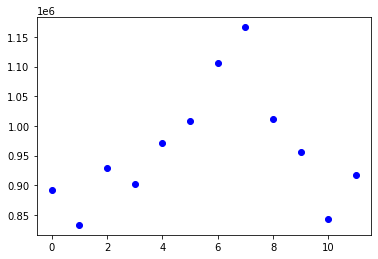

In [ ]:
#Get the reference value per year
years=[]
vols=[]
for y in df2['Year'].unique().tolist():
  vol=df2[df2['Year']==y]['Total'].sum()
  years.append(y)
  vols.append(vol)
vols=[v/vols[0] for v in vols]
#plt.plot(years, vols)
Ky={key:val for key, val in zip(years, vols)}

tmp=[]
for i in range(len(df2)):
  if(df2.iloc[i]['Year']<=2019):
    tmp.append(df2.iloc[i]['Total']/Ky[df2.iloc[i]['Year']])
  else:
    tmp.append(0)
df2['TotalNormalized']=tmp

Vm={}
for m in range(1,13):
  Vm[m]=df2[(df2['Year']<=2019) & (df2['Month']==m)]['TotalNormalized'].mean()
plt.plot(list(Vm.values()),'ob')
#print(Vm)

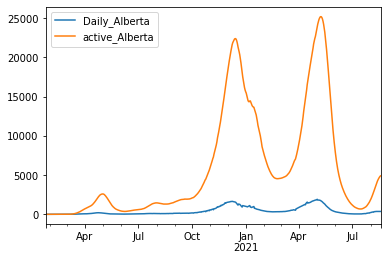

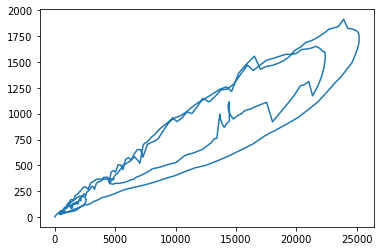

In [ ]:
df['Daily_Alberta'].plot()
df['active_Alberta'].plot()
plt.legend()
plt.figure()
plt.plot(df['active_Alberta'],df['Daily_Alberta'],'-')

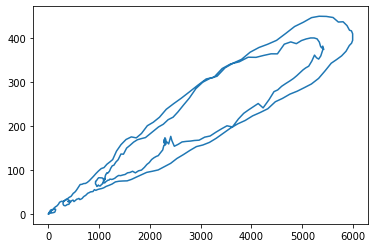

In [ ]:
#df[['Daily_Manitoba','active_Manitoba']].plot()
plt.plot(df['active_Manitoba'],df['Daily_Manitoba'])
with open('manitoba.txt','w') as f:
  for i in range(len(df)):
    f.write(str(df.iloc[i]['Daily_Manitoba'])+'\n')
  